In [1]:
from LZGraphs import NaiveLZGraph,generate_kmer_dictionary

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm
mpl.rcParams['figure.figsize'] = (15,7)
import numpy as np

/home/thomas/Desktop/LZGraphs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The Data Used

The NaiveLZGraph works on nucleotide sequences and is best suited for feature extraction / comparison as it has a constant number of nodes selected by the user and the only learnable factor in this model is the edge weights and the connections between the different nodes

first we will load the sequence we will use from out example datasets:

In [2]:
example_sequences = pd.read_csv('ExampleData1.csv',
                               index_col=0)
example_sequences

,cdr3_rearrangement
9482,TGCGCCAGCAGCCAAGACCTGCGATTGATGTCCCGTAGTCCCTATG...
14823,TGTGCCAGCACTCCCCCACAGGGCTATGAAGCTTTCTTT
8994,TGTGCCAGCAGTACTGGGACTAGCGGGGTGAATGAGCAGTTCTTC
12490,TGTGCCAGCAGCGTAGGAGCGACGACAGGGGGCGCGGGGAATGAGC...
22854,TGCAGCGCACGAAGTGAGGAGAACACTGAAGCTTTCTTT
...,...
23751,TGTGCCTGGAGTGTTCTATTGGAGACCCAGTACTTC
14861,TGTGCCAGCAGTTACGACGCGAACACTGAAGCTTTCTTT
20944,TGCGCCAGCAGCGGTGCTGGGGGGTCCCAAGAGACCCAGTACTTC
7836,TGTGCCAGCAGCGCACGGACTAGCGGGGAGACAGATACGCAGTATTTT


# Generating Node Dictionary

The next step in create a NaiveLZGraph is creating a list of nodes it will try to form connections between and aggregate the transition proibabilites between them.

Naturally if we were to use only 4 nodes (A,T,C,G) we wolud get a simple first-order markov-chain.

In the context of the NaiveLZGraph we want all LZ sub-patterns that can appear, from the our research in T-Cell CDR3 sequences, the maximum observed length of an LZ sub-patterns is 6, thus we reccomend using 6 as the parameter for the dictionary generating function.

below is an example of the dictionary generation function and the output it returns

In [3]:
lz_dictionary = generate_kmer_dictionary(6)

In [4]:
lz_dictionary[15:25]

['GC', 'CA', 'CT', 'CG', 'CC', 'AAA', 'AAT', 'AAG', 'AAC', 'ATA']

# Creating The NaiveLZGraph

In order to create an instance of a NaiveLZGraph all we need is to provide the class constructor with the list of sequence we want our graph to learn and the node dictionary we already generated using `generate_dictionary`.

Below is an example of the graph creation:

In [5]:
my_naive_lzgraph = NaiveLZGraph(example_sequences['cdr3_rearrangement'],lz_dictionary)

We can see from the verbose generated the amount of time it took to create the graph and the different steps taken along the way.

A good sanity check that the graph creation was indeed correct and that we accidentally didnt pass the name of the column by mistake or any other non sequence strings is to check the list of edges in the graph, see example below:

In [6]:
len(my_naive_lzgraph.edges)

5137

We can see above that over the 5000 sequences we had in our example file we have discovered 5137 unique edges which means no issues on your side.
One should double check if he get less than 30 edges for any number of sequences larger than 30.

# Using The NaiveLZGraph

### 1. Deriving a Featrure Vector

One of the best usecases of the NaiveLZGraph as already mentioned, is the generation of a feature vector that can be used to model / compare any number of repertoires.

Naturally, based on the fact we use the same nodes in every graph we will get unique feature vectors for every repertoire we model using the approach above, the NaiveLZGraph guarantees us that all of the feature vectors will be of the same dimension, a key fact that other graph types can not guarantee.

In [7]:
feature_vector = my_naive_lzgraph.eigenvector_centrality()

In [8]:
type(feature_vector)

dict

The eigenvector_centrality method will return the eigenvector centrality value for each node in your NaiveLZGraph, the output is a dictionary, to further use this feature vector you would want to extract the values of the output dictionary and convert it to a numpy array:

In [9]:
feature_vector = np.array(list(feature_vector.values()))

In [10]:
feature_vector

array([3.03155935e-01, 1.17814853e-01, 1.18110181e-01, ...,
       6.99936298e-10, 6.99936298e-10, 6.99936298e-10], shape=(5460,))

### 2. Deriving LZPgen

Below is an example of how one can derive the LZPgen based on the NaiveLZGraph.
Although we do not recommend using the NaiveLZGraph for LZPgen calculation as it does not satisfy the DAG constraint presented in our paper.

In [11]:
lzpgens = []
# iterate over each sequence
for sequence in example_sequences['cdr3_rearrangement']:
    # convert sequence to graph sub-patterns
    walk = NaiveLZGraph.encode_sequence(sequence)
    # calculate the lzpgen based on the fitted NaiveLZGraph
    lzpgen = my_naive_lzgraph.walk_probability(walk,verbose=False)
    lzpgens.append(lzpgen)

Text(0.5, 0, '-log10(NaiveLZPgen)')

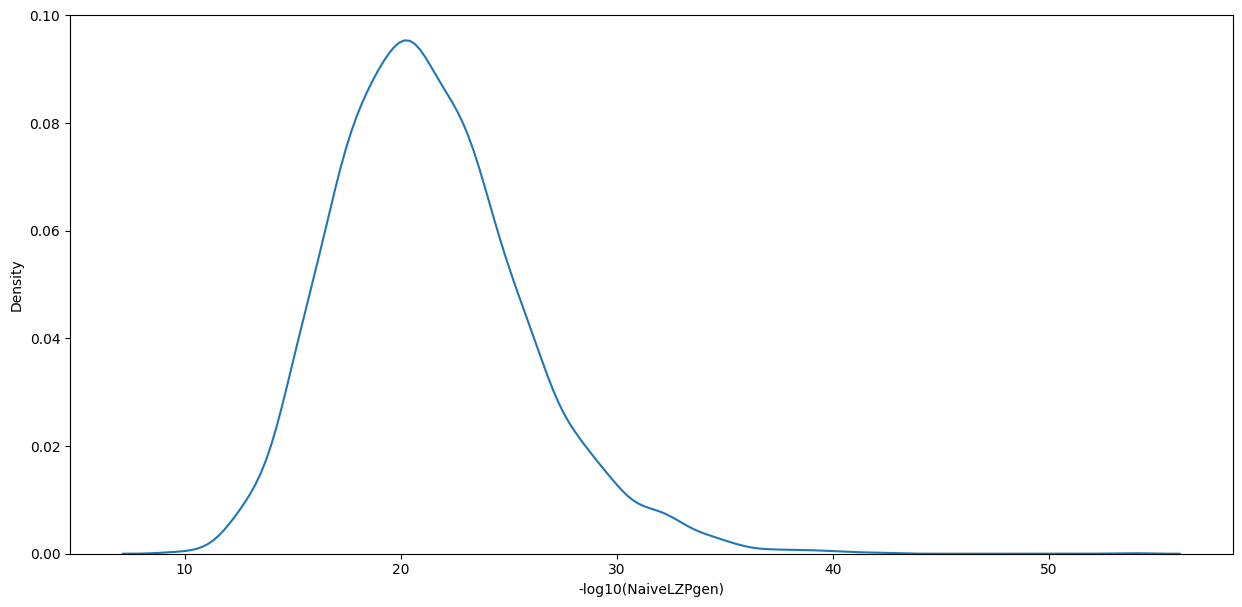

In [12]:
sns.kdeplot(-np.log10(lzpgens))
plt.xlabel('-log10(NaiveLZPgen)')

### 3. Generating Sequences

Below is an example of how one can generate new sequences using the NaiveLZGraph.
Although we do not recommend using the NaiveLZGraph sequence generation it does not satisfy the DAG constraint presented in our paper it still can be used to generate less spesific sequences to the source repertoire statistics.

In [13]:
my_naive_lzgraph.unsupervised_random_walk()

(['T', 'G', 'TG', 'C'], 'TGTGC')

The above call to the `unsupervised_random_walk` method will generate a sequence starting in a random initial state and will terminate at the first teminal state it reaches.
The method returns the steps taken (the actual graph nodes) and the resulting sequence.

In [14]:
my_naive_lzgraph.random_walk(25)

(['T',
  'G',
  'TG',
  'A',
  'GCG',
  'GA',
  'CAG',
  'TAC',
  'AC',
  'TGA',
  'AG',
  'AGG',
  'ACA',
  'CC',
  'CG',
  'CAG',
  'AG',
  'AC',
  'AA',
  'GA',
  'GCC',
  'AG',
  'AC',
  'TT',
  'C'],
 'TGTGAGCGGACAGTACACTGAAGAGGACACCCGCAGAGACAAGAGCCAGACTTC')

The above method `random_walk` will geneate a sequence of a given length (in the above example is 25) and will return the taken graph steps and the resulting sequence.

### 4. Graph Summary

The `graph_summary()` method provides a quick overview of your NaiveLZGraph's key statistics:

In [15]:
my_naive_lzgraph.graph_summary()

Chromatic Number        25
Number of Isolates    5199
Max In Deg             105
Max Out Deg            110
Number of Edges       5137
dtype: int64

### 5. Saving and Loading Graphs

Once you've built a NaiveLZGraph, you can save it to disk for later use:

In [16]:
# Save the graph to disk (pickle format)
my_naive_lzgraph.save('my_naive_lzgraph.pkl')

# Load the graph back
loaded_naive_graph = NaiveLZGraph.load('my_naive_lzgraph.pkl')
print(f"Loaded graph has {len(loaded_naive_graph.nodes)} nodes and {len(loaded_naive_graph.edges)} edges")

Loaded graph has 5460 nodes and 5137 edges


### 6. Information-Theoretic Metrics

LZGraphs provides entropy-based metrics to analyze the diversity and complexity of your repertoire:

In [17]:
from LZGraphs import node_entropy, edge_entropy, graph_entropy

# Calculate node entropy (diversity of nodes)
node_ent = node_entropy(my_naive_lzgraph)
print(f"Node Entropy: {node_ent:.4f}")

# Calculate edge entropy (diversity of transitions)
edge_ent = edge_entropy(my_naive_lzgraph)
print(f"Edge Entropy: {edge_ent:.4f}")

# Calculate graph entropy (combined measure)
graph_ent = graph_entropy(my_naive_lzgraph)
print(f"Graph Entropy: {graph_ent:.4f}")

Node Entropy: 5.5911
Edge Entropy: 3.4974
Graph Entropy: 9.0885


You can also calculate the perplexity of individual sequences:

In [18]:
from LZGraphs import sequence_perplexity

# Calculate perplexity for a single sequence
sample_seq = example_sequences['cdr3_rearrangement'].iloc[0]
perplexity = sequence_perplexity(my_naive_lzgraph, sample_seq)
print(f"Sequence: {sample_seq}")
print(f"Perplexity: {perplexity:.4f}")

Sequence: TGCGCCAGCAGCCAAGACCTGCGATTGATGTCCCGTAGTCCCTATGGCTACACCTTC
Perplexity: 23.8640


### 7. Comparing Two Repertoires

You can compare two repertoires using Jensen-Shannon divergence:

In [19]:
from LZGraphs import jensen_shannon_divergence

# Create a second graph from a subset of sequences
subset_sequences = example_sequences['cdr3_rearrangement'].iloc[:2500]
second_naive_graph = NaiveLZGraph(subset_sequences, lz_dictionary)

# Calculate Jensen-Shannon divergence between the two repertoires
js_divergence = jensen_shannon_divergence(my_naive_lzgraph, second_naive_graph)
print(f"Jensen-Shannon Divergence: {js_divergence:.6f}")
print("(Lower values indicate more similar repertoires)")

Jensen-Shannon Divergence: 0.000540
(Lower values indicate more similar repertoires)


### 8. Error Handling

LZGraphs provides custom exceptions for clear error messages:

In [20]:
from LZGraphs import MissingNodeError

# Example: Handling unknown nodes in walk probability
try:
    # Create an invalid walk with nodes not in the graph
    unknown_walk = ['UNKNOWN_NODE_1', 'UNKNOWN_NODE_2']
    prob = my_naive_lzgraph.walk_probability(unknown_walk, verbose=False)
    print(f"Probability for unknown walk: {prob}")
    print("(Note: NaiveLZGraph returns 0.0 for unknown nodes rather than raising an exception)")
except MissingNodeError as e:
    print(f"Error type: {type(e).__name__}")
    print(f"Message: {e}")

Probability for unknown walk: 0.0
(Note: NaiveLZGraph returns 0.0 for unknown nodes rather than raising an exception)


### Cleanup

Remove temporary files created during this tutorial:

In [21]:
import os
# Remove saved graph file
if os.path.exists('my_naive_lzgraph.pkl'):
    os.remove('my_naive_lzgraph.pkl')
    print("Cleaned up temporary files.")

Cleaned up temporary files.
